# Telegram Spam Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch

import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maukanmir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  df[col].value_counts().plot.bar()
  
def remove_stop_words(review:str):

    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/dataset.csv")
df

,text_type,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...
...,...,...
20343,ham,/ban
20344,ham,/ban
20345,ham,/ban
20346,ham,Kaisi hii


# Check For Nulls & Dupes

In [4]:
print(f"# Null values: {df.isna().sum()}")
print(f"# Dupe values: {df.duplicated().sum()}")

# Null values: text_type    0
text         0
dtype: int64
# Dupe values: 14


In [6]:
df[df.duplicated()]

,text_type,text
20329,ham,SPAM DETECTION User: Username: @DillyBubb...
20330,ham,SPAM DETECTION User: Username: @DillyBubb...
20331,ham,SPAM DETECTION User: Username: @DillyBubb...
20332,ham,SPAM DETECTION User: Username: @DillyBubb...
20334,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
20335,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
20336,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
20337,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
20338,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
20339,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.dtypes

text_type    object
text         object
dtype: object

# Check class imbalances

Class=spam, Count=6011, Percentage=29.561%
Class=ham, Count=14323, Percentage=70.439%


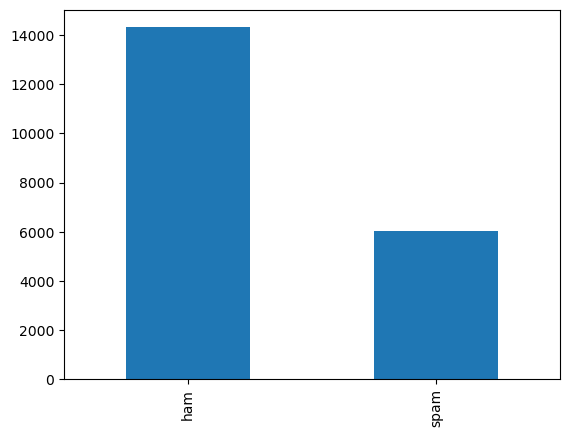

In [10]:
check_class_imbalance(df,df['text_type'], 'text_type')

In [11]:
df.shape

(20334, 2)

# Data Preprocessing

In [14]:
df

KeyError: 20329